In [97]:
from folktables import ACSDataSource
import folktables
import pandas as pd
import numpy as np
import random
import pickle
from collections import defaultdict
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import numpy as np
from bestLS_hindsight import *
from OnlineRidgeRiver import *
from lean_adahedge import *
import matplotlib.pyplot as plt
from bestLS_hindsight_together import *
from oridge_alwaysactive_implementable import *


from folktables.load_acs import state_list

In [2]:
df_all = pd.read_pickle("allstates2021.pkl")

In [3]:
df_all

,AGEP,WKHP,PINCP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,...,SEX_2,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9
0,0.025316,0.295918,0.039472,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0.037975,0.397959,0.030967,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.025316,0.173469,0.030467,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0.215190,0.051020,0.053479,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,0.025316,0.091837,0.009455,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630162,0.291139,0.397959,0.399670,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1630163,0.379747,0.397959,0.299615,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1630164,0.367089,0.397959,0.092501,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1630165,0.063291,0.295918,0.060483,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
X_dat = df_all.drop('PINCP', axis=1) #dropping the income column
y_dat = pd.DataFrame(df_all['PINCP']) # picking up only the income column for the target

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
def get_feature_importance(weights, feature_names):
    '''
        Returns a dictionary with importance for each feature (one hot encoded ones are mapped back to a single feautere)
    '''
    di_imp = defaultdict(int)
    for w, name in zip(weights, feature_names):
        fn_snip = name.split('_')[0] # if underscore wasn't there just picks the name, otherwise splits acc to underscore and picks first
        di_imp[fn_snip] += w**2 # absolute value of weight added
    return di_imp

In [12]:
model_lr = LinearRegression(n_jobs = -1) # use all cores to build model

In [13]:
model_lr.fit(X_dat , y_dat)

LinearRegression(n_jobs=-1)

In [44]:
model_lr.score(X_dat, y_dat) 

0.48367663299831687

In [42]:
y_pred = model_lr.predict(X_dat) 
print(r2_score(y_dat, y_pred)) #0.48 R2 score

0.48367663299831687


In [47]:
model_ridge = Ridge() # default alpha is 1.0
model_ridge.fit(X_dat , y_dat)

Ridge()

In [48]:
model_ridge.score(X_dat, y_dat)

0.4836814544979555

In [34]:
weights = model_lr.coef_.ravel()

In [38]:
di_imp = get_feature_importance(weights, X_dat.columns)

In [39]:
di_imp

defaultdict(int,
            {'AGEP': 0.03513697546490057,
             'WKHP': 0.13291193431037376,
             'COW': 1.046698411799209e+16,
             'SCHL': 66451018516.78597,
             'MAR': 3.637861570874854e+16,
             'OCCP': 1.4613010604946746e+21,
             'SEX': 1.048501153268975e+20,
             'RAC1P': 1.1329847230447944e+20})

In [112]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, TargetEncoder, StandardScaler, OneHotEncoder
def numeric_scaler(df, cols):
    '''
    df: pandas dataframe
    numeric_cols: (array of strings) column names for numeric variables

    no return: does inplace operation
    '''
    df_new = df.copy()
    mmscaler = MinMaxScaler()
    df_new[cols] = mmscaler.fit_transform(df_new[cols])
    return df_new

def ordinal_encoder(df, cols): # similar to label encoder which only works for targets?
    '''
    Encode categorical into 0 ... n-1
    '''
    df_new = df.copy()
    ordinal_enc = OrdinalEncoder()
    df_new[cols] = ordinal_enc.fit_transform(df_new[cols])
    return df_new

def oh_sklearn(df, cols):
    pass
    # Issues with this operation as it doesnt preseve number of columns etc, the dummies method below works
    # df_new = df.copy()
    # oh_enc = OneHotEncoder()
    # df_new[cols] = oh_enc.fit_transform(df_new[cols])
    # return df_new

def one_hot(df, cols): # idk if sklearns one-hot encoder is similar
    """
    df: pandas DataFrame
    param: cols a list of columns to encode 
    return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

def target_encoder(df, x_cols, y_col):
    df_new = df.copy()
    enc_auto = TargetEncoder(smooth="auto", target_type="continuous")
    df_new[x_cols] = enc_auto.fit_transform(df_new[x_cols], df[y_col])
    return df_new

def target_encoder2(df, x_cols, y_col):
    df_new = df.copy()
    enc_auto = TargetEncoder(smooth="auto", target_type="continuous")
    df_new[x_cols] = enc_auto.fit_transform(df_new[x_cols], df[y_col])
    return df_new, enc_auto

In [3]:
# testing on non one hot encoded

ACSIncome = folktables.BasicProblem(
    features=[
#         'ST',
        'AGEP', #Numeric, age of householder
        'COW',  #Categorical, class of worker 
        'SCHL', #Categorical, educational attainment
        'MAR', #Categorical, Mamarital status 5 categories 
        'OCCP', #Categorical, occupation lots of codes here
#         'POBP', #place of birth, US states, and if international has places
#         'RELSHIPP', #Relationship, renamed to Relantioship in the new PUMS syntax, 20 - 38
        'WKHP', #Numeric, hours worked per week in last 12 months
        'SEX',  #Categorical Male, Female 2 
        'RAC1P', #Categorical Recoded detailed race code, 9 categories here 1)White ... 9
    ],
    target='PINCP',
    group = 'RAC1P', #ignore this flag
    preprocess=folktables.adult_filter, # age of householder > 16, etc.., see acs.py in folktables
    postprocess=lambda x: np.nan_to_num(x, -1),
) #default ACSIncome Pull above

# random.seed(42) not shuffling, state wise round robin, kind of non-stochastic setting
# random.shuffle(state_list)
print('Selected states: ', state_list)
data_source = ACSDataSource(survey_year='2021', horizon='1-Year', survey='person')
acs_data = data_source.get_data(state_list, download=True)

Selected states:  ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']


In [31]:
X, y, gr = ACSIncome.df_to_pandas(acs_data)
dataset = pd.concat([X, y], axis=1)

In [33]:
dataset

,AGEP,COW,SCHL,MAR,OCCP,WKHP,SEX,RAC1P,PINCP
0,19.0,2.0,18.0,5.0,4760.0,30.0,2.0,1.0,8000.0
1,20.0,1.0,19.0,5.0,4640.0,40.0,1.0,2.0,6300.0
2,19.0,2.0,18.0,5.0,5240.0,18.0,2.0,1.0,6200.0
3,34.0,2.0,19.0,3.0,4220.0,6.0,2.0,1.0,10800.0
4,19.0,1.0,18.0,5.0,2722.0,10.0,1.0,1.0,2000.0
...,...,...,...,...,...,...,...,...,...
1630162,40.0,1.0,21.0,5.0,1430.0,40.0,2.0,9.0,80000.0
1630163,47.0,2.0,22.0,1.0,2205.0,40.0,1.0,9.0,60000.0
1630164,46.0,4.0,21.0,1.0,5740.0,40.0,2.0,9.0,18600.0
1630165,22.0,6.0,21.0,5.0,2634.0,30.0,1.0,9.0,12200.0


In [35]:
#important to explicity define columns with categoricals as ints to index properly into them
dataset['COW'] = dataset['COW'].astype(int)
dataset['SCHL'] = dataset['SCHL'].astype(int)
dataset['MAR'] = dataset['MAR'].astype(int)
dataset['OCCP'] = dataset['OCCP'].astype(int)
dataset['SEX'] = dataset['SEX'].astype(int)
dataset['RAC1P'] = dataset['RAC1P'].astype(int)

In [36]:
data_incomeless200k = dataset[dataset['PINCP'] <= 2e5]
top_200OCCP = dataset['OCCP'].value_counts()[:250].index.tolist() # top 200 occupation codes in the original dataframe
data_fil = data_incomeless200k[data_incomeless200k['OCCP'].isin(top_200OCCP)]
print(len(data_fil) / len(dataset)) #top200 occp codes and <= 200k is 83 % of original dataset

0.8761574734367706


In [117]:
from sklearn.model_selection import train_test_split

df_fil_train, df_fil_test = train_test_split(data_fil, test_size=0.2)

# df_fil_train, df_fil_test
# len(df_fil_train)/ (len(df_fil_train) + len(df_fil_test)) 

0.7999997199434565

In [118]:
# target encodings followed by minmax scaling all, just using TRAIN DATA
categorical_cols = ['COW','SCHL', 'MAR', 'OCCP', 'SEX', 'RAC1P']
df_te, te_trfit = target_encoder2(df_fil_train, categorical_cols, ['PINCP']) # returns modified dataframe as well as target encoder object which has learnt the transformation
df_te_scaled = numeric_scaler(df_te, df_te.columns)

# df_te_scaled.head()

X_dat_te_scaled = df_te_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_te_scaled = pd.DataFrame(df_te_scaled['PINCP']) # picking up only the income column for the target

model_lr_te_scaled = LinearRegression(n_jobs = -1)
model_lr_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"LR score on target encoding and scaled {model_lr_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")

model_ridge_te_scaled = Ridge()
model_ridge_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"Ridge score on target encoding and scaled {model_ridge_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")

model_lasso_te_scaled = Lasso() # kinda garbage , all zeros for weight?
model_lasso_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"Lasso score on target encoding and scaled {model_lasso_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")

#TODO try r2 scores on some unseen data, using transform, dont do fit transform from target_encoder!

/Users/krisacha/anaconda3/envs/multigroup/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR score on target encoding and scaled 0.4656838691354256
Ridge score on target encoding and scaled 0.46568386895596003
Lasso score on target encoding and scaled 0.0


In [127]:
df_te_test = df_fil_test.copy()
df_te_test[categorical_cols] = te_trfit.transform(df_te_test[categorical_cols]) # using target encoder fitted on df_fil_train
df_test_te_scaled = numeric_scaler(df_te_test, df_te_test.columns)

X_dat_test_te_scaled = df_test_te_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_test_te_scaled = pd.DataFrame(df_test_te_scaled['PINCP']) # picking up only the income column for the target

model_lr_test_te_scaled = LinearRegression(n_jobs = -1)
model_lr_test_te_scaled.fit(X_dat_test_te_scaled, y_dat_test_te_scaled)
print(f"LR score on target encoding and scaled {model_lr_test_te_scaled.score(X_dat_test_te_scaled, y_dat_test_te_scaled)}") #good r2 score on test too!


LR score on target encoding and scaled 0.4662467793371893


In [126]:
df_test_te_scaled

,AGEP,COW,SCHL,MAR,OCCP,WKHP,SEX,RAC1P,PINCP
1139538,0.217949,0.570100,0.982866,0.000000,0.485006,0.397959,0.0,0.721492,0.254090
310829,0.243590,0.570100,0.255286,0.000000,0.057917,0.214286,1.0,0.721492,0.057982
204117,0.448718,0.570100,0.303277,0.696557,0.536642,0.551020,1.0,0.721492,0.349642
1074027,0.679487,0.570100,0.812543,0.696557,0.317940,0.448980,1.0,0.165465,0.958977
452676,0.500000,0.570100,0.411967,1.000000,0.503323,0.397959,0.0,0.721492,0.524739
...,...,...,...,...,...,...,...,...,...
810867,0.512821,0.862932,0.411967,1.000000,0.815653,0.602041,1.0,0.721492,1.000000
235738,0.512821,0.570100,0.303277,1.000000,0.574038,0.061224,0.0,0.721492,0.013958
1540486,0.589744,0.653125,0.640085,1.000000,0.468525,0.234694,0.0,0.721492,0.509730
1061370,0.166667,0.570100,0.303277,1.000000,0.685173,0.397959,1.0,0.721492,0.202061


In [ ]:
te_trfit.transform()

In [73]:
X_dat_acs = data_fil.drop('PINCP', axis=1) #dropping the income column
y_dat_acs = pd.DataFrame(data_fil['PINCP']) # picking up only the income column for the target
# just using the default encodings given in dataset, NOT Even scaled
model_lr_acs = LinearRegression(n_jobs = -1) # use all cores to build model
model_lr_acs.fit(X_dat_acs, y_dat_acs)
model_lr_acs.score(X_dat_acs, y_dat_acs)

0.37049427559931525

In [74]:
# scaling all og encodings of acs using numeric scaler, almost same r2 score as above
df_acsencodings_scaled = numeric_scaler(data_fil, data_fil.columns)
X_dat_acs_scaled = df_acsencodings_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_acs_scaled = pd.DataFrame(df_acsencodings_scaled['PINCP']) # picking up only the income column for the target

model_lr_acs_scaled = LinearRegression(n_jobs = -1)
model_lr_acs_scaled.fit(X_dat_acs_scaled, y_dat_acs_scaled)
model_lr_acs_scaled.score(X_dat_acs_scaled, y_dat_acs_scaled)

0.3704942755993147

In [75]:
# ordinal encoding of categoric followed by minmax scaling of all columns
# using ordinal encodings for categorical, then minmax scaling all, not principled but anyway.., minute bump in r2 score
categorical_cols = ['COW','SCHL', 'MAR', 'OCCP', 'SEX', 'RAC1P']
df_ordinal = ordinal_encoder(data_fil, categorical_cols)
df_ordinal_scaled = numeric_scaler(df_ordinal, df_ordinal.columns) # scaling all columns here

X_dat_ord_allscaled = df_ordinal_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_ord_allscaled = pd.DataFrame(df_ordinal_scaled['PINCP']) # picking up only the income column for the target


model_lr_ordinal_allscaled = LinearRegression(n_jobs = -1)
model_lr_ordinal_allscaled.fit(X_dat_ord_allscaled, y_dat_ord_allscaled)
model_lr_ordinal_allscaled.score(X_dat_ord_allscaled, y_dat_ord_allscaled)

0.37505966799974755

In [102]:
data_fil

,AGEP,COW,SCHL,MAR,OCCP,WKHP,SEX,RAC1P,PINCP
0,19.0,2,18,5,4760,30.0,2,1,8000.0
1,20.0,1,19,5,4640,40.0,1,2,6300.0
2,19.0,2,18,5,5240,18.0,2,1,6200.0
3,34.0,2,19,3,4220,6.0,2,1,10800.0
4,19.0,1,18,5,2722,10.0,1,1,2000.0
...,...,...,...,...,...,...,...,...,...
1630162,40.0,1,21,5,1430,40.0,2,9,80000.0
1630163,47.0,2,22,1,2205,40.0,1,9,60000.0
1630164,46.0,4,21,1,5740,40.0,2,9,18600.0
1630165,22.0,6,21,5,2634,30.0,1,9,12200.0


In [99]:
# target encodings followed by minmax scaling all, USING Target encoder old one
categorical_cols = ['COW','SCHL', 'MAR', 'OCCP', 'SEX', 'RAC1P']
df_te = target_encoder(data_fil, categorical_cols, ['PINCP'])
df_te_scaled = numeric_scaler(df_te, df_te.columns)

# df_te_scaled.head()

X_dat_te_scaled = df_te_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_te_scaled = pd.DataFrame(df_te_scaled['PINCP']) # picking up only the income column for the target

model_lr_te_scaled = LinearRegression(n_jobs = -1)
model_lr_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"LR score on target encoding and scaled {model_lr_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")

model_ridge_te_scaled = Ridge()
model_ridge_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"Ridge score on target encoding and scaled {model_ridge_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")

model_lasso_te_scaled = Lasso() # kinda garbage , all zeros for weight?
model_lasso_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"Lasso score on target encoding and scaled {model_lasso_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")

#TODO try r2 scores on some unseen data, using transform, dont do fit transform from target_encoder!

/Users/krisacha/anaconda3/envs/multigroup/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR score on target encoding and scaled 0.4657885318923807
Ridge score on target encoding and scaled 0.4657885317767201
Lasso score on target encoding and scaled 0.0


In [100]:
model_lasso_te_scaled.coef_

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [90]:
df_te_scaled.describe()

,AGEP,COW,SCHL,MAR,OCCP,WKHP,SEX,RAC1P,PINCP
count,1.428283e+06,1.428283e+06,1.428283e+06,1.428283e+06,1.428283e+06,1.428283e+06,1.428283e+06,1.428283e+06,1.428283e+06
mean,3.318182e-01,6.010992e-01,4.396685e-01,6.171714e-01,3.493485e-01,3.744374e-01,5.047707e-01,5.979388e-01,2.533181e-01
std,1.956121e-01,1.176823e-01,2.325424e-01,4.521444e-01,2.028869e-01,1.310068e-01,4.972896e-01,2.647814e-01,2.037726e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.645570e-01,5.697645e-01,2.544899e-01,9.823312e-04,1.920848e-01,3.469388e-01,2.239559e-03,3.028767e-01,9.950473e-02
50%,3.291139e-01,5.710511e-01,3.044830e-01,9.965160e-01,3.126735e-01,3.979592e-01,9.931332e-01,7.248884e-01,1.995598e-01
75%,4.936709e-01,6.498886e-01,6.360905e-01,9.981073e-01,5.005458e-01,3.979592e-01,9.965252e-01,7.271626e-01,3.496423e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


[0.15842867 0.06435285 0.15871977 0.03247738 0.37611711 0.34215615
 0.03670554 0.02470359]


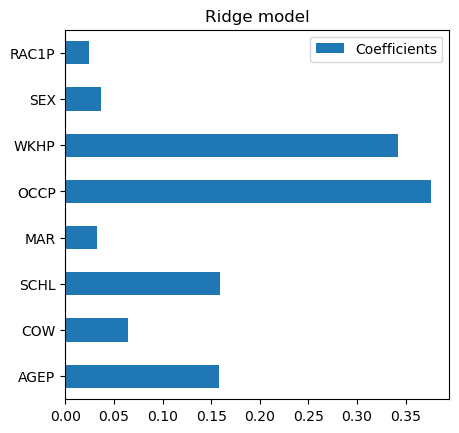

In [95]:
#plotting weights of the Linear regression model
print(model_lr_te_scaled.coef_.ravel())
coefs = pd.DataFrame(
    model_lr_te_scaled.coef_.ravel(), columns=["Coefficients"], index=X_dat_te_scaled.columns
)

# most important seem to be OCCP, WKHP, SCHL, AGEP, COW
coefs.plot(kind="barh")
plt.title("Ridge model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)


[0.15842172 0.06455013 0.15870555 0.03247702 0.37688302 0.34214442
 0.03668347 0.02520665]


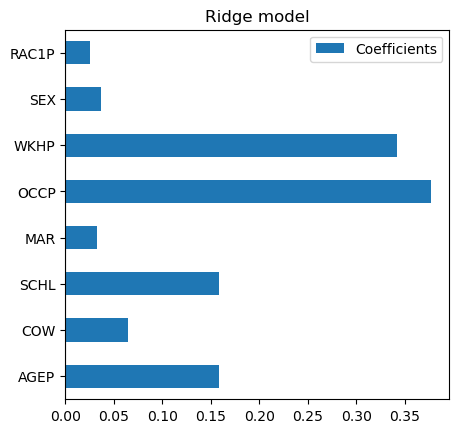

In [101]:
#plotting weights of the Linear regression model
print(model_ridge_te_scaled.coef_.ravel())
coefs = pd.DataFrame(
    model_ridge_te_scaled.coef_.ravel(), columns=["Coefficients"], index=X_dat_te_scaled.columns
)

# most important seem to be OCCP, WKHP, SCHL, AGEP, COW
coefs.plot(kind="barh")
plt.title("Ridge model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)


In [78]:
data_fil.dtypes

AGEP     float64
COW        int64
SCHL       int64
MAR        int64
OCCP       int64
WKHP     float64
SEX        int64
RAC1P      int64
PINCP    float64
dtype: object

In [57]:
from collections import Counter
print(Counter(df_ordinal['OCCP']))
print(df_ordinal['OCCP'].describe())

Counter({20.0: 41072, 240.0: 36593, 103.0: 33898, 74.0: 32040, 156.0: 31803, 158.0: 30084, 172.0: 28305, 154.0: 26846, 245.0: 26727, 187.0: 25058, 142.0: 24088, 131.0: 20294, 247.0: 18144, 197.0: 17502, 135.0: 17494, 34.0: 17264, 43.0: 16088, 72.0: 16083, 116.0: 15378, 80.0: 15074, 75.0: 14814, 190.0: 13648, 235.0: 13416, 168.0: 13368, 6.0: 13000, 178.0: 12963, 144.0: 12518, 117.0: 12127, 143.0: 11963, 195.0: 11629, 162.0: 11558, 165.0: 11487, 0.0: 10854, 1.0: 10571, 13.0: 10163, 222.0: 10101, 70.0: 9893, 149.0: 9850, 30.0: 9579, 12.0: 9568, 155.0: 9249, 163.0: 9170, 200.0: 9131, 26.0: 8963, 132.0: 8906, 192.0: 8822, 78.0: 8790, 127.0: 8776, 134.0: 8765, 232.0: 8755, 11.0: 8529, 211.0: 8321, 15.0: 8304, 191.0: 8147, 73.0: 8099, 29.0: 8071, 126.0: 7944, 216.0: 7870, 220.0: 7518, 48.0: 7293, 147.0: 7257, 17.0: 7082, 45.0: 7030, 57.0: 6557, 180.0: 6540, 193.0: 6210, 185.0: 6053, 243.0: 5975, 5.0: 5925, 227.0: 5916, 69.0: 5829, 33.0: 5822, 112.0: 5760, 67.0: 5708, 161.0: 5650, 202.0: 5643,

In [ ]:
df_oh_check

In [14]:
from sklearn.preprocessing import MinMaxScaler
def numeric_scaler(df, numeric_cols):
    '''
    df: pandas dataframe
    numeric_cols: (array of strings) column names for numeric variables

    no return: does inplace operation
    '''
    numeric_scaler = MinMaxScaler()
    df[numeric_cols] = numeric_scaler.fit_transform(df[numeric_cols])

In [15]:
dataset_cp = dataset
numeric_scaler(dataset_cp, dataset_cp.columns)

In [17]:
X_dat_noh = dataset_cp.drop('PINCP', axis=1) #dropping the income column
y_dat_noh = pd.DataFrame(dataset_cp['PINCP']) # picking up only the income column for the target

In [21]:
model_lr_notonehot_mmscaled = LinearRegression(n_jobs = -1) # use all cores to build model
model_lr_notonehot_mmscaled.fit(X_dat_noh, y_dat_noh)
model_lr_notonehot_mmscaled.score(X_dat_noh, y_dat_noh)


0.23386053772833315

In [25]:
dataset

,AGEP,COW,SCHL,MAR,OCCP,WKHP,SEX,RAC1P,PINCP
0,19.0,2.0,18.0,5.0,4760.0,30.0,2.0,1.0,8000.0
1,20.0,1.0,19.0,5.0,4640.0,40.0,1.0,2.0,6300.0
2,19.0,2.0,18.0,5.0,5240.0,18.0,2.0,1.0,6200.0
3,34.0,2.0,19.0,3.0,4220.0,6.0,2.0,1.0,10800.0
4,19.0,1.0,18.0,5.0,2722.0,10.0,1.0,1.0,2000.0
...,...,...,...,...,...,...,...,...,...
1630162,40.0,1.0,21.0,5.0,1430.0,40.0,2.0,9.0,80000.0
1630163,47.0,2.0,22.0,1.0,2205.0,40.0,1.0,9.0,60000.0
1630164,46.0,4.0,21.0,1.0,5740.0,40.0,2.0,9.0,18600.0
1630165,22.0,6.0,21.0,5.0,2634.0,30.0,1.0,9.0,12200.0


In [26]:
X_dat_noh = dataset_cp.drop('PINCP', axis=1) #dropping the income column
y_dat_noh = pd.DataFrame(dataset_cp['PINCP']) # picking up only the income column for the target